## Abstract

Despite the header being `## Abstract`, this section will render as a highlighted section titled *Summary*.

----

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on AirTable, SlackBot will message you an AI disclosure that you should place here.
:::


## Introduction

##### Protein language models have emerged as powerful tools for computational biology applications including fitness prediction, generative protein design, structure prediction, and functional annotation. These models are trained on vast databases of naturally occurring protein sequences with the expectation that they will capture complex relationships underlying these sequences—from fundamental biophysical constraints to evolutionary pressures that have shaped modern proteins. However, the extent to which these models have learned genuine evolutionary principles versus surface-level sequence patterns, and how this varies across model architectures, remains an open question.

##### Ancestral sequence reconstruction (ASR) provides a compelling framework for addressing this question. ASR employs statistical methods to infer the most probable protein sequences of extinct ancestral organisms based on phylogenetic relationships among extant sequences. While these reconstructions may not represent the exact sequences that existed in the past, they reflect evolutionarily plausible intermediates under established models of molecular evolution, and in many cases have been shown to fold and function. This approach offers two key advantages for probing evolutionary knowledge encoded in protein language models. First, reconstructed ancestral sequences are absent from training datasets, which consist exclusively of extant sequences, providing an opportunity to evaluate the ability of these models to generalize to new sequences. Second, these sequences are generated through principled statistical methods based on established evolutionary models, providing sequences with known evolutionary plausibility. ASR has been successfully applied to reconstruct and experimentally characterize diverse protein families, demonstrating that many reconstructed sequences represent functionally viable proteins. This creates an opportunity to assess model confidence in evolutionarily plausible sequences that were never observed during training, while examining how this confidence varies with both the inferred age of ancestral proteins and the statistical confidence of the reconstructions themselves.



## ADA1 ancestral reconstruction as test case

##### We began this analysis with the human protein ADA1, an adenosine deaminase that plays a crucial role in purine metabolism. ADA1 offered several advantages as a test case: it is relatively small (363 amino acids) for computationally intensive pseudo-perplexity calculations, and it is fairly well conserved, allowing for high-confidence sequence alignments and ancestral reconstructions.

##### We performed ASR on ADA1 by identifying homologs using Protein Cartography, aligning proteins with MAFFT, building a phylogenetic tree with IQTree, reconstructing maximum likelihood ancestral sequences using PAML, and inferring insertions and deletions using PastML. We then evaluated the ouput reconstructed ancestral sequences using multiple sizes of the ESM2 protein language model family, employing pseudo-perplexity as our primary metric.

::: {.callout-note}
The ancestral reconstructions were performed outside of this notebook, in the notebook `ASR/ASR_notebook.ipynb` with output files in `ASR/ADA1_ASR`.  This step was conducted separately to keep the main analysis here focused and uncluttered, as ancestral reconstruction involves a multi-stage pipeline with its own set of dependencies and intermediate steps. The reconstruction can be reproduced by running the notebook in an environment with the required dependencies specified in `envs/asr_env.yaml`. The notebook will output the reconstructed ancestral sequences in FASTA format, which can then be used as input for the pseudo-perplexity calculations.
:::

##### Pseudo-perplexity quantifies how well a protein language model can predict each amino acid in a sequence given the surrounding context, essentially measuring the model’s "surprise" at encountering each individual residue. In this framework, a value near 20 suggests that the model is highly uncertain and assigns roughly equal probability to all 20 amino acids, while a value closer to 1 indicates strong confidence in its prediction. In practice, pseudo-perplexity is computed by summing the negative log-likelihoods of each residue prediction across the entire sequence, yielding a sequence-level score that reflects how grammatically consistent a model believes the sequence to be based on its training on natural proteins. Lower pseudo-perplexity values therefore suggest higher plausibility under the model’s learned distribution. By systematically analyzing pseudo-perplexity scores across ancestral sequences spanning different evolutionary depths, we aimed to assess whether protein language models can effectively infer the plausibility of ancestrally reconstructed sequences and how their confidence varies across evolutionary time.


## ADA1 phylogeny

##### We first wanted to assess how ESM2 pseudo-perplexity varies between ancestral and native sequences, as well as the effect of ancestral age.  To start, we looked at the human ADA1 protein P00813.  Below is its location in our ADA1 phylogenetic tree.

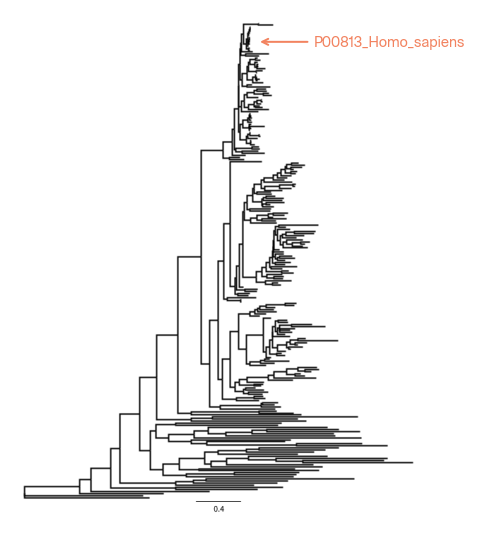

In [1]:
# | code-fold: true
# | label: fig-1
# | fig-cap: Here is some text


import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import seaborn as sns
import arcadia_pycolor as apc
from data_processing import plot_image_with_arrows, plot_image_with_arrow_and_circles

apc.mpl.setup()

img_path = 'images/ADA1_tree.png'
plot_image_with_arrows(
    img_path,
    x_starts=[0.73],
    x_ends=[0.60],
    arrow_ys=[0.045],
    labels=['P00813_Homo_sapiens'],
    text_offsets=[0.01]
)

##### We first determined every ancestral node leading to this extant leaf and the maximum likelihood ancestral sequence of this node. To clarify what we mean by this, below is an example of all ancestral nodes (orange circles) on the lineage of an example leaf of interest (orange arrow).  We excluded the basal node of the tree as our ASR pipeline does not reconstruct this node.

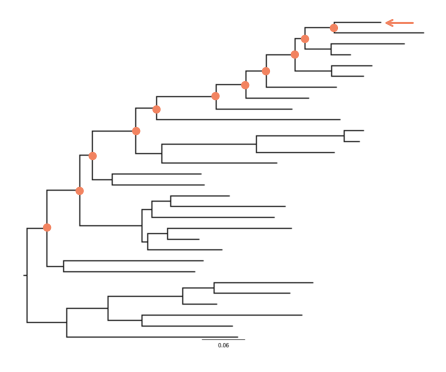

In [2]:
# | code-fold: true
# | label: fig-2
# | fig-cap: Here is some text

node_img_path = 'images/tree_nodes_example.png'
plot_image_with_arrow_and_circles(
    img_path=node_img_path,
    x_start=0.97,
    x_end=0.89,
    arrow_y=0.01,
    circle_positions=[(0.771, 0.025),(0.70,0.058),(0.675,0.105),(0.604,0.155),(0.553,0.197),
    (0.48,0.23),(0.335,0.27),(0.285,0.335),(0.178,0.41),(0.146,0.515),
    (0.066,0.625)],
    circle_radius=6
)

## Loading the data

##### We calculated pseudo-perplexity scores using the 650M parameter ESM2 model for relevant ancestral sequences and extant sequences in our dataset. 

::: {.callout-note}
This analysis was performed on an Amazon EC2 g4dn.2xlarge instance using the custom script `esm2_pppl_calculator.py`. Because this required GPU compute for efficient execution, it was conducted separately from the main notebook. To reproduce the analysis, follow the instructions provided in `README.md` and run the script in an environment configured with the dependencies listed in `envs/esm2_env.yaml`.
:::

##### In addition to pseudo-perplexity values, we extracted the mean posterior probabilities for each ancestral reconstruction from the PAML output. Posterior probability in this context represents the statistical confidence of the maximum likelihood reconstruction.  Specifically, it quantifies the probability that each amino acid at each position in the ancestral sequence is correctly inferred given the phylogenetic model and observed extant sequences. Higher mean posterior probabilities indicate greater confidence in the protein reconstruction, with values approaching 1.0 representing near-certainty in the inferred ancestral state.

##### To quantify evolutionary divergence, we calculated the cumulative branch length from the root to each ancestral node and extant leaf in our phylogenetic tree. These root-to-tip distances serve as a proxy for evolutionary time and the extent of sequence divergence from the common ancestor, allowing us to examine how ESM2 confidence varies across different evolutionary depths.



In [3]:
import pandas as pd
import json
import numpy as np
from Bio import Phylo

# Import ADA1 sequences scored for ESM2 pppl
all_scores = pd.read_csv('ESM2_scoring/ADA1_all_esm2_scores_650M.csv')
all_scores = all_scores[['sequence_id', 'sequence', 'pseudo_perplexity']]

# Retrieve ML posterior probabilities from ASR run
ml_probs_json = 'ASR/ADA1_ASR/posterior_probabilities_no_gaps.json'
with open(ml_probs_json) as f:
    probs_dict = json.load(f)

# Add posterior probabilities to dataframe
all_scores['ML prob'] = all_scores['sequence_id'].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)

# Import phylogenetic tree to infer ancestors of leaf of interest
tree_file = "ASR/ADA1_ASR/ancestor_tree.txt"
tree = Phylo.read(tree_file, "newick")

# Calculate the branch length to the root for every ancestor and native sequence
from data_processing import calc_branch_length_to_root_node, calc_branch_length_to_root_leaf

all_scores['bl_to_root'] = all_scores['sequence_id'].apply(
    lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))


## Visualizing ESM2 pseudo-perplexity vs. evolutionary distance

##### We can then plot ESM2 pseudo-perplexity scores against evolutionary distance from the tree root, with the extant human ADA1 sequence shown in orange and ancestral sequences color-coded by their mean posterior probability values. This allows us to examine the effect of both ancestral age (distance to tree root) and reconstruction confidence (posterior probability) on the pseudo-perplexity score.

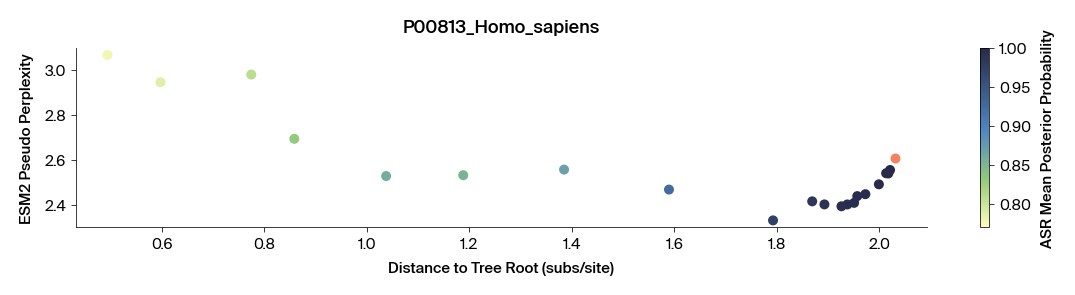

In [4]:
# | label: fig-3
# | fig-cap: Here is some text

import matplotlib.pyplot as plt
from data_processing import get_node_labels_leaf_to_root, plot_evo_path

plot_evo_path(all_scores, tree, 'P00813_Homo_sapiens')

##### This shows an intriguing relationship. Most notably, ESM2 assigns lower pseudo-perplexity scores to recent ancestral sequences compared to the extant human sequence, suggesting that the model considers these reconstructed ancestors more plausible than the native sequence. This is notable given that these ancestral sequences were never present in the training data, indicating that ESM2 has internalized evolutionary patterns sufficiently to recognize high-confidence ancestral reconstructions as evolutionarily sound.

##### However, as evolutionary distance increases, pseudo-perplexity scores begin to rise and eventually surpass the native score, suggesting the model finds these basal ancestors less plausible than the native sequence, and less plausible than more recent ancestral sequences. Two mechanisms probably explain this behavior. (1) The ancestral reconstructions have low posterior support, so ESM2 rates them as less plausible. (2) Because the model is partly over-fit to extant-like sequences, plausibility drops as sequences deviate from its training distribution. Both effects likely contribute to the higher pseudo-perplexity observed for basal ancestors.  

##### We wondered how general this phenomena was, so we examined three additional extant leaves in our ADA1 phylogenetic tree (shown below) and ancestral nodes on their respective lineages.


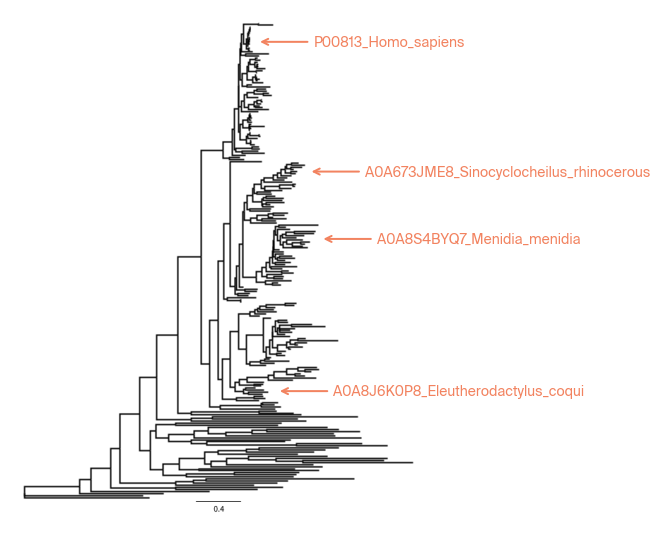

In [5]:
# | code-fold: true
# | label: fig-4
# | fig-cap: Here is some text

plot_image_with_arrows(
    img_path,
    x_starts=[0.73,0.89,0.86, 0.78],
    x_ends=[0.60,0.76,0.73, 0.65],
    arrow_ys=[0.045,0.44,0.305, 0.745],
    labels=['P00813_Homo_sapiens',  'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui'],
    text_offsets=[0.01, 0.01, 0.01, 0.01]
)

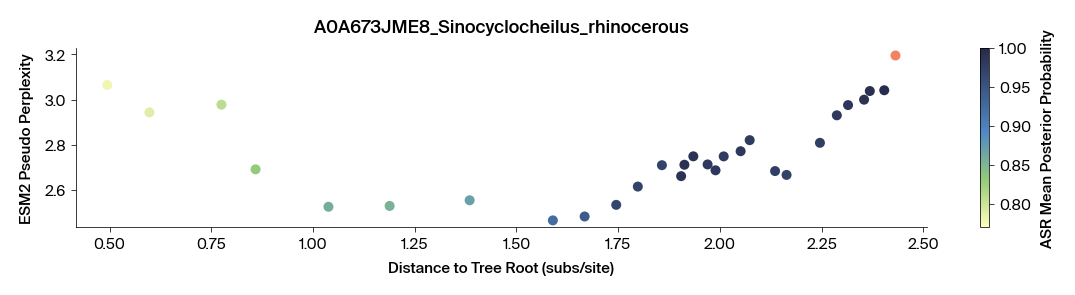

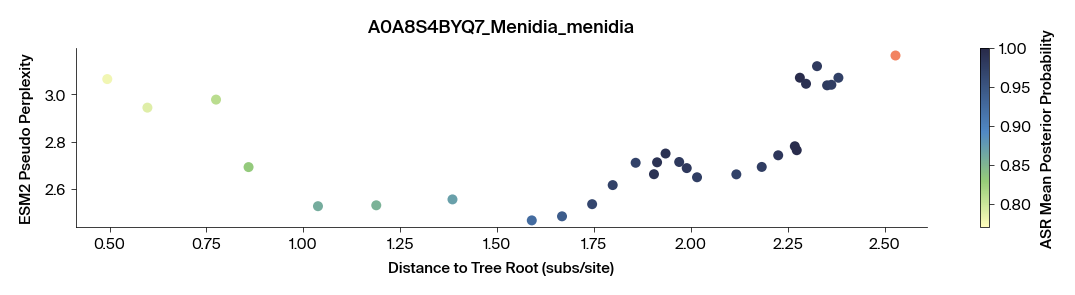

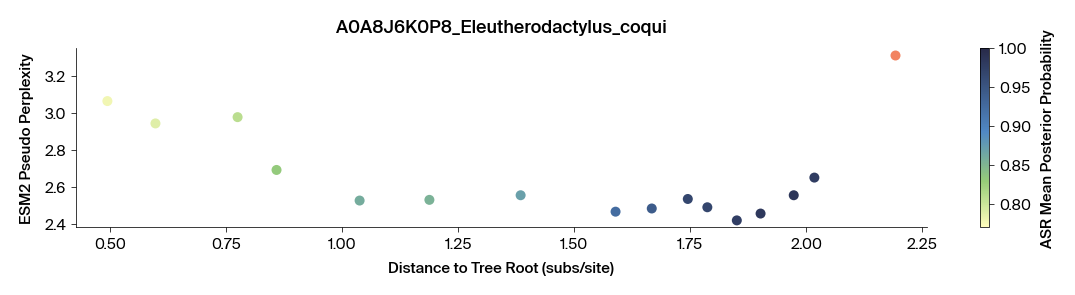

In [6]:
# | label: fig-5
# | fig-cap: Here is some text

plot_evo_path(all_scores, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path(all_scores, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path(all_scores, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')

##### Here we see a similar pattern: recent ancestors show lower pseudo-perplexity scores than their native descendants, but these scores increase for the oldest ancestors. Unlike human ADA1, however, none of these other ancestors showed higher pseudo-perplexity scores than their native sequences, suggesting this is not universal. This may reflect the lower baseline score of human ADA1 compared to the others, perhaps due to over-representation of human and closely related sequences in the training set compared to these other species. However we consistently observe that ESM2 considers many ancestral sequences more plausible than native sequences across different species.

## Assessing the role of consensus effects

##### We wondered whether ESM’s general preference for ancestral sequences reflects primarily a consensus effect in these models. Maximum likelihood ancestral reconstructions, while statistically based, often favor amino acids that are common among descendant sequences, potentially creating sequences that align with the frequency distributions in the ESM2 training data. Therefore ESM2 might prefer these sequences simply because they contain high frequency amino acids.

##### To test this hypothesis, we generated "consensus ancestors" as controls. For each ancestral node, we identified all extant sequences descending from that node and constructed a consensus sequence by choosing the most frequent amino acid found at each position in the alignment.. This overly simplistic approach differs fundamentally from maximum likelihood reconstruction, which incorporates evolutionary models, branch lengths, and substitution matrices to infer the most probable ancestral state given the entire phylogenetic context.

In [7]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from data_processing import generate_node_consensus, get_node_labels_leaf_to_root

leaves_of_interest = ['P00813_Homo_sapiens', 'A0A8S4BYQ7_Menidia_menidia', 'A0A673JME8_Sinocyclocheilus_rhinocerous', 'A0A8J6K0P8_Eleutherodactylus_coqui'] 
ancestors_of_interest = []

for entry in leaves_of_interest:
    ancestors_of_interest.extend(get_node_labels_leaf_to_root(tree, entry))

ancestors_of_interest = list(set(ancestors_of_interest))

alignment_file = 'ASR/ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft.fa'
name_conv_dict = 'ASR/ADA1_ASR/recoding_dict.txt'
gap_dict_json = 'ASR/ADA1_ASR/gap_positions.json'

consensus_seq_file = 'ESM2_scoring/consensus_ancestors/consensus_ADA1_ancestors.fa'

records = []
for entry in ancestors_of_interest:
    consensus_seq = generate_node_consensus(tree, entry, alignment_file, name_conv_dict, gap_dict_json)
    name = entry + '_consensus'
    record = SeqRecord(Seq(consensus_seq), id=name, description="")
    records.append(record)

# # Write all consensus sequences to a FASTA file
# with open(consensus_seq_file, 'w') as file:
#     SeqIO.write(records, file, "fasta")


##### We then calculated pseudo-perplexity scores for these consensus ancestors using the ESM2 650M parameter model, as before.

In [8]:
# retrieve esm2 scores for consensus seqs
consensus_file = 'ESM2_scoring/consensus_ancestors/consensus_ADA1_ancestors_esm2_scores_650M.csv'
consensus_scores = pd.read_csv(consensus_file)
consensus_scores['orig_id'] = consensus_scores['sequence_id'].apply(lambda x: x.replace('_consensus', ''))
consensus_scores = consensus_scores[['orig_id', 'sequence', 'pseudo_perplexity']]
consensus_scores = consensus_scores.rename(columns={'sequence': 'consensus_seq', 'pseudo_perplexity': 'consensus_pppl', 'orig_id':'sequence_id'})


# add new consensus seqs and scores to scores df
all_scores = all_scores.merge(consensus_scores, how='left', on='sequence_id')

##### Below we compared the ESM2 pseudo-perplexity scores of these consensus ancestors to the scores of genuine maximum likelihood ancestors for the four extant sequences we previously examined.  Here we plot the scores for both, with an arrow indicating whether the ML ancestor has a lower pseudo-perplexity score (blue) or the consensus ancestor has a lower pseudo-perplexity score (yellow).

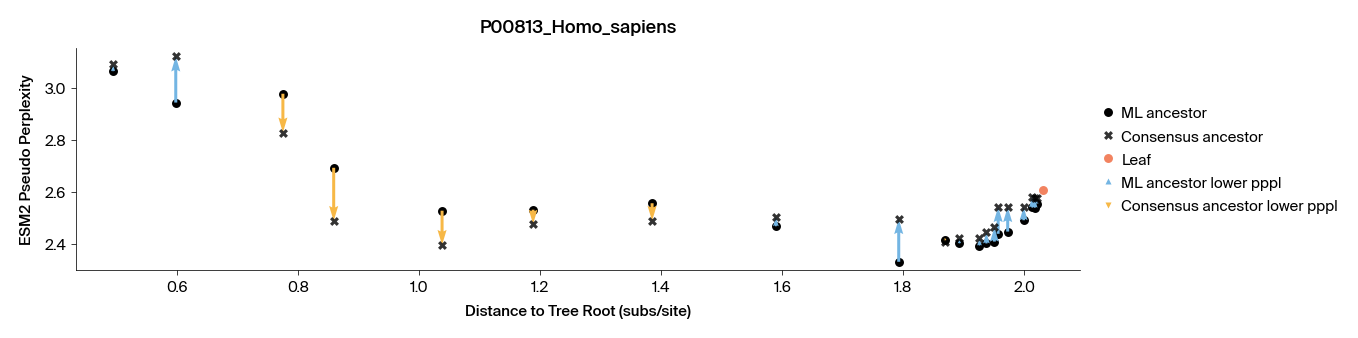

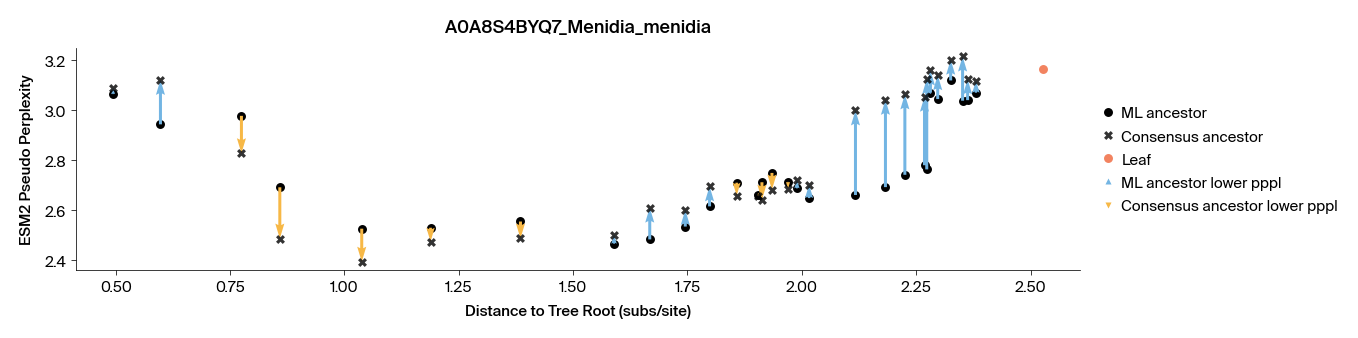

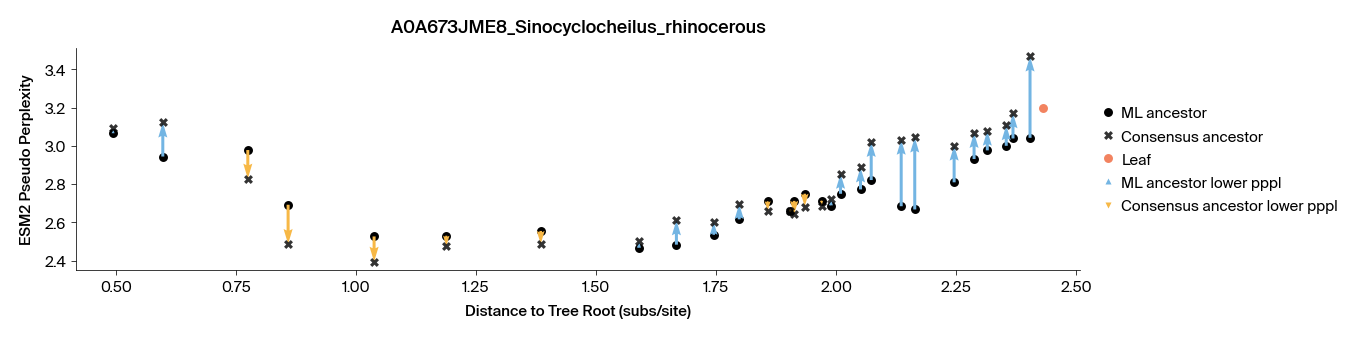

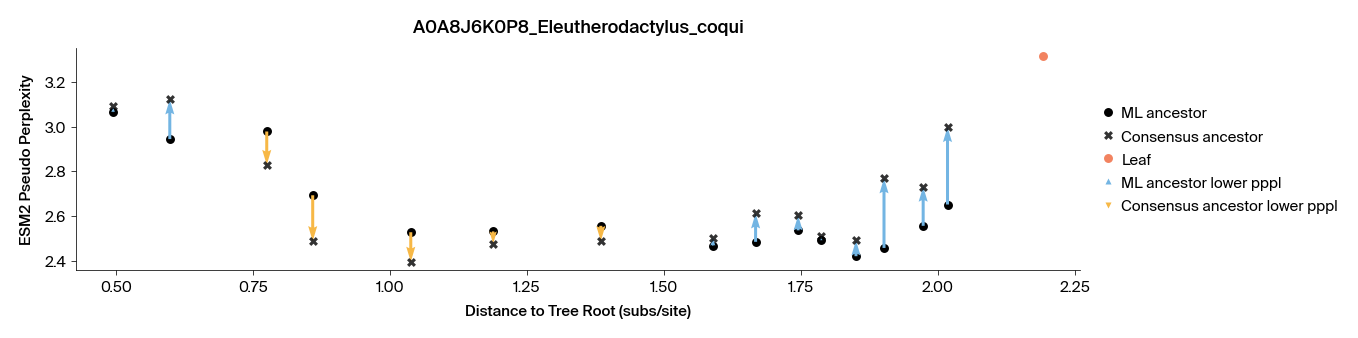

In [9]:
# | label: fig-6
# | fig-cap: Here is some text

from data_processing import plot_evo_path_quiver

plot_evo_path_quiver(all_scores, tree, 'P00813_Homo_sapiens')
plot_evo_path_quiver(all_scores, tree, 'A0A8S4BYQ7_Menidia_menidia')
plot_evo_path_quiver(all_scores, tree, 'A0A673JME8_Sinocyclocheilus_rhinocerous')
plot_evo_path_quiver(all_scores, tree, 'A0A8J6K0P8_Eleutherodactylus_coqui')

##### This analysis shows that maximum likelihood ancestors frequently achieve lower pseudo-perplexity scores than their corresponding consensus ancestors. However, both types of ancestral sequences frequently scored lower than extant sequences, indicating that the observed preference for ancestral sequences is likely at least partially driven by a consensus effect.

##### The relationship between maximum likelihood and consensus ancestors varies with evolutionary distance. For recent ancestors, maximum likelihood sequences consistently outperform consensus ancestors, suggesting that ESM2 has learned to recognize evolutionarily informed reconstructions as more plausible than simple frequency-based sequences. This indicates that the model has internalized aspects of evolutionary relationships beyond mere amino acid frequency distributions. However, this relationship reverses for more ancient ancestors, where consensus sequences often achieve lower pseudo-perplexity scores than maximum likelihood reconstructions. Given that these ancient reconstructions also exhibit lower posterior probabilities, this reversal may reflect increased uncertainty and potential errors in the maximum likelihood reconstructions. Alternatively, this behavior could reflect over-fitting to native sequences given that consensus sequences likely more closely match the frequency distributions of the training set. While it’s difficult to distinguish between these two factors for the oldest ancestors, for more recent ancestors it’s clear that ESM2 can infer that maximum likelihood ancestors are significantly more plausible than crude consensus ancestors.



## Comparing different ESM2 model sizes

##### We were curious how much of the evolutionary information ESM2 seems to be learning is consistent across different model sizes, or whether this information is only captured in large models. To investigate this, we repeated the above analysis with different ESM2 model sizes: 8M, 35M, 150M, and 3B parameters (in addition to the previously shown 650M). 

In [10]:
small_model_scores = pd.read_csv('ESM2_scoring/ADA1_all_esm2_scores_8M.csv')
med_model_scores = pd.read_csv('ESM2_scoring/ADA1_all_esm2_scores_35M.csv')
large_model_scores = pd.read_csv('ESM2_scoring/ADA1_all_esm2_scores_150M.csv')
huge_model_scores = pd.read_csv('ESM2_scoring/ADA1_all_esm2_scores_3B.csv')

small_model_scores['ML prob'] = small_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
small_model_scores['bl_to_root'] = small_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

med_model_scores['ML prob'] = med_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
med_model_scores['bl_to_root'] = med_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

large_model_scores['ML prob'] = large_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
large_model_scores['bl_to_root'] = large_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))

huge_model_scores['ML prob'] = huge_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
huge_model_scores['bl_to_root'] = huge_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(tree, x))




##### We can then plot the same relationship between ESM2 pseudo-perplexity and distance to tree root for these different model sizes to see if they exhibit similar behavior. 

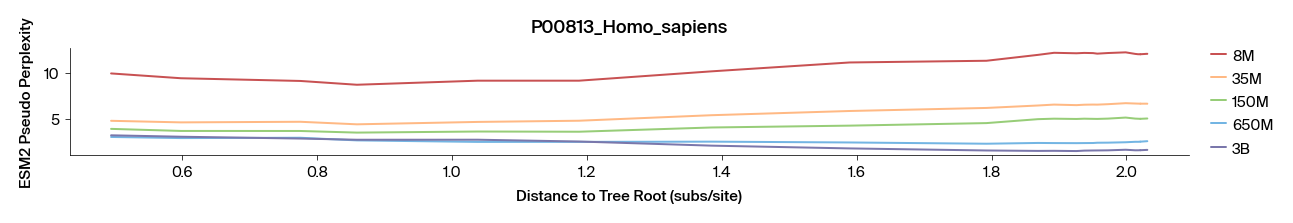

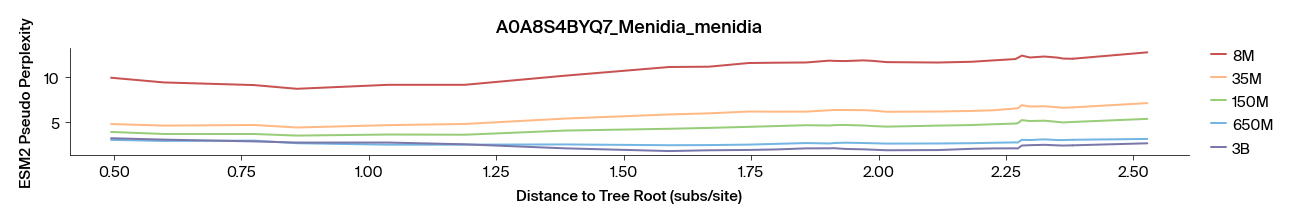

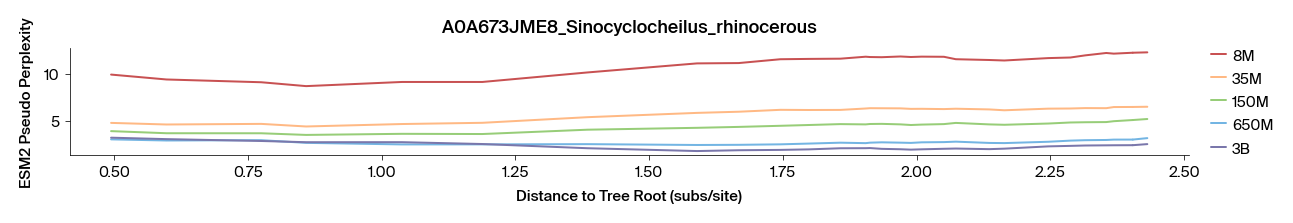

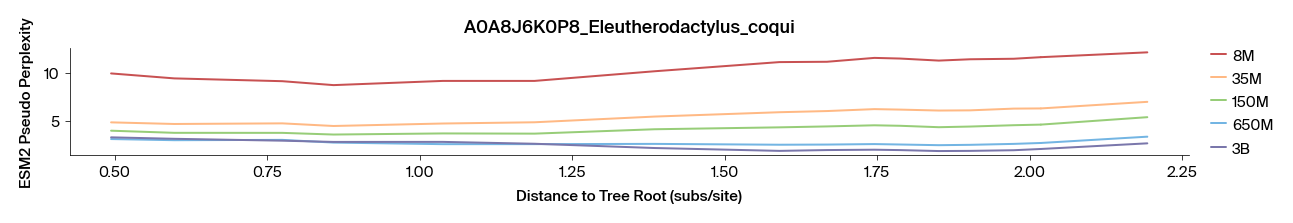

In [11]:
# | label: fig-7
# | fig-cap: Here is some text

from data_processing import plot_multiple_evo_lines

plot_multiple_evo_lines([(small_model_scores, 'P00813_Homo_sapiens', '8M'),(med_model_scores, 'P00813_Homo_sapiens', '35M'),(large_model_scores, 'P00813_Homo_sapiens', '150M'),(all_scores, 'P00813_Homo_sapiens', '650M'),(huge_model_scores, 'P00813_Homo_sapiens', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '8M'),(med_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '35M'),(large_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '150M'),(all_scores, 'A0A8S4BYQ7_Menidia_menidia', '650M'),(huge_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '8M'),(med_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '35M'),(large_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '150M'),(all_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '650M'),(huge_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '3B')], tree, normalize = False)
plot_multiple_evo_lines([(small_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '8M'),(med_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '35M'),(large_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '150M'),(all_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '650M'),(huge_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '3B')], tree, normalize = False)


##### The most prominent pattern is that larger models consistently produce lower pseudo-perplexity scores overall, reflecting their enhanced ability to learn protein sequence distributions. However, the relationship between pseudo-perplexity and evolutionary distance varies systematically across model sizes. To facilitate comparison across models with different baseline scores, we normalized all pseudo-perplexity values relative to the corresponding extant sequence score for each model. 


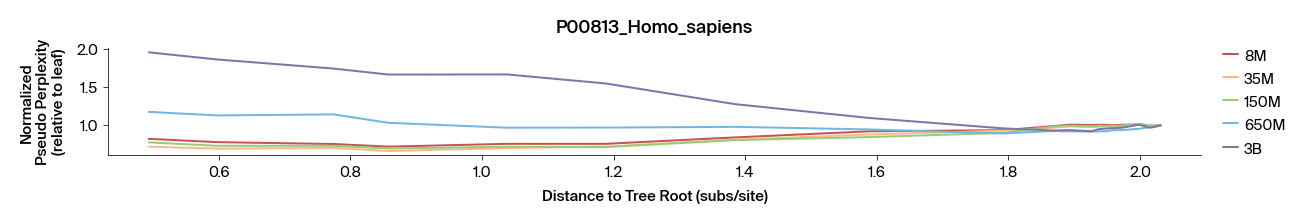

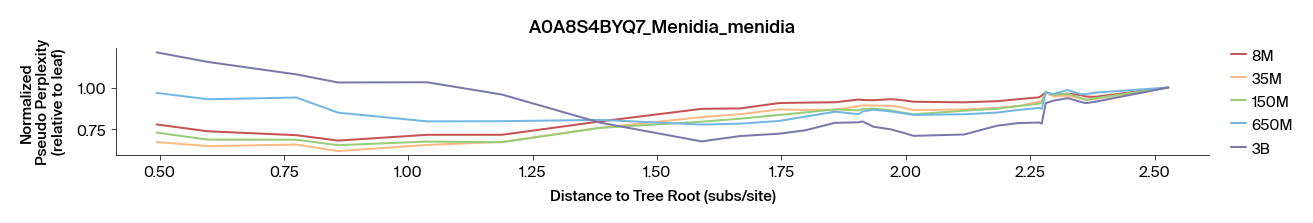

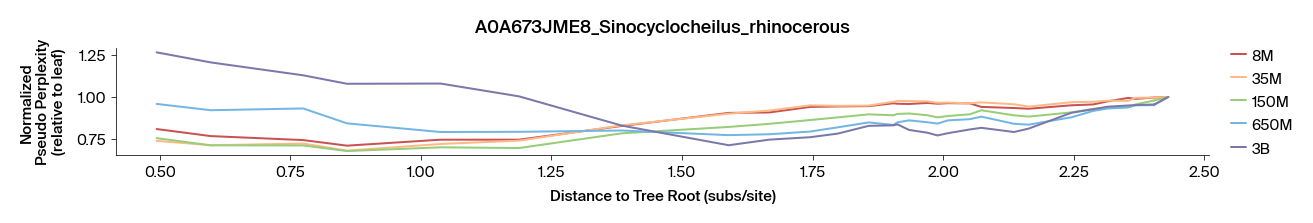

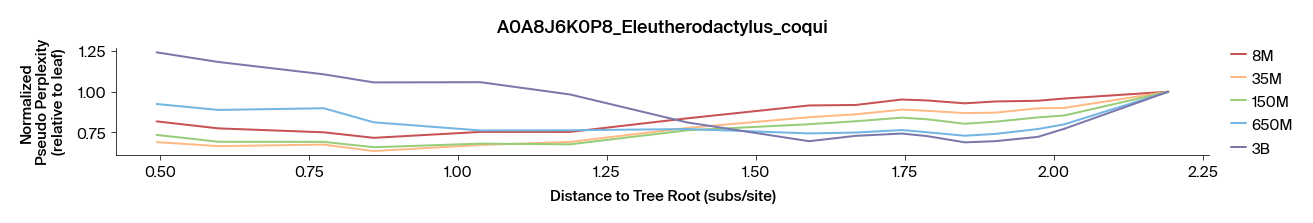

In [12]:
# | label: fig-8
# | fig-cap: Here is some text

plot_multiple_evo_lines([(small_model_scores, 'P00813_Homo_sapiens', '8M'),(med_model_scores, 'P00813_Homo_sapiens', '35M'),(large_model_scores, 'P00813_Homo_sapiens', '150M'),(all_scores, 'P00813_Homo_sapiens', '650M'),(huge_model_scores, 'P00813_Homo_sapiens', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '8M'),(med_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '35M'),(large_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '150M'),(all_scores, 'A0A8S4BYQ7_Menidia_menidia', '650M'),(huge_model_scores, 'A0A8S4BYQ7_Menidia_menidia', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '8M'),(med_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '35M'),(large_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '150M'),(all_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '650M'),(huge_model_scores, 'A0A673JME8_Sinocyclocheilus_rhinocerous', '3B')], tree)
plot_multiple_evo_lines([(small_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '8M'),(med_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '35M'),(large_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '150M'),(all_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '650M'),(huge_model_scores, 'A0A8J6K0P8_Eleutherodactylus_coqui', '3B')], tree)

##### This normalization reveals distinct differences in how models of varying sizes score ancestors of different ages. The larger models (650M and 3B parameters) show dramatic increases in pseudo-perplexity for the oldest ancestors compared to recent ancestors or extant sequences, while the smallest models show only gradual increases for these ancient sequences. Conversely, the largest models demonstrate the greatest decreases in pseudo-perplexity for the most recent ancestors relative to extant sequences.

##### These patterns suggest the models learn evolutionary principles to markedly different extents. The largest models disfavor low-confidence reconstructions while favoring high-confidence reconstructions. This could reflect genuine evolutionary learning or overfitting to native-like sequences. Meanwhile, the smallest models show minimal pseudo-perplexity differences from native to deepest ancestors, though their absolute scores remain quite high (>10) compared to the much lower scores (<3) of larger models.

##### Most importantly, these results demonstrate that ESM2 model size is critically important for evolutionary analysis. Depending on which model size you use for this type of analysis, you could reach vastly different conclusions: that all ancestors are more plausible than native sequences, that some ancestors are more plausible, that ancestors and native sequences are similarly plausible, or that ancestral age strongly affects plausibility.


## Second example gene: yeast isomaltase

##### To test whether these observations hold more broadly, we examined yeast isomaltase, a gene from a different species with unrelated function but similar phylogenetic properties. We selected this gene because it produced high-quality alignments and phylogenetic trees and was relatively small for pseudo-perplexity calculations (589 amino acids). Most notably, we selected this gene because it showed a similar phylogenetic structure with very high confidence reconstructions toward terminal leaves and lower (but still reasonable) confidence at basal nodes. While not all gene phylogenies follow this pattern, we wanted to understand how ESM2 behaves with this fairly typical phylogenetic structure. Future work could expand this analysis to genes with more diverse phylogenetic patterns to examine how pseudo-perplexity varies across different tree topologies.

##### We selected three extant leaves to interrogate in the same manner as above, their location on the isomaltase phylogenetic tree is shown below.


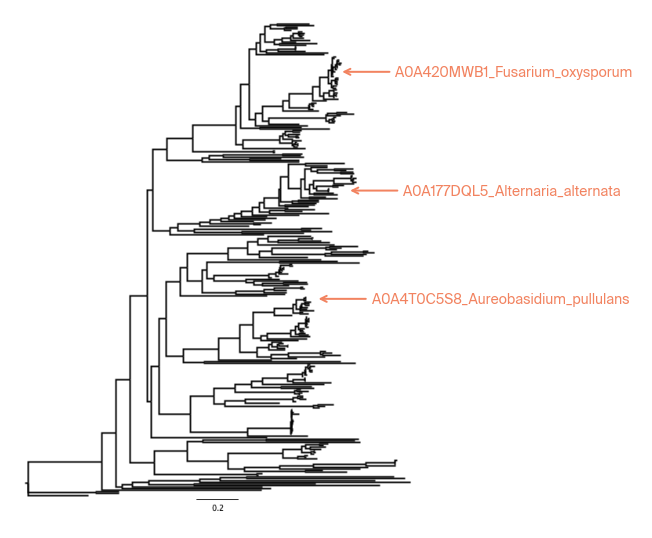

In [13]:
# | code-fold: true
# | label: fig-9
# | fig-cap: Here is some text

img_path = 'images/isomaltase_tree.png'
plot_image_with_arrows(
    img_path,
    x_starts=[0.94, 0.96, 0.88],
    x_ends=[0.81, 0.83, 0.75],
    arrow_ys=[0.105, 0.343, 0.56],
    labels=['A0A420MWB1_Fusarium_oxysporum', 'A0A177DQL5_Alternaria_alternata', 'A0A4T0C5S8_Aureobasidium_pullulans'],
    text_offsets=[0.01, 0.01, 0.01]
)

##### It’s worth noting that the scale of substitutions per site is much smaller for isomaltase compared to ADA1, indicating that these sequences are less divergent (maximum branch length ~1.5 vs ~2.5 for ADA1). Correspondingly, the overall ASR mean posterior probabilities are also higher.

##### We can then plot the ESM2 pseudo-perplexity (650M parameter model) compared to the distance to tree root as we did for ADA1 for all three leaves.


In [14]:
# get ESM2 scores for isomaltase
iso_scores = pd.read_csv('ESM2_scoring/isomaltase_all_esm2_scores_650M.csv')

# retrieve the dictionary of probabilities from PAML output
ml_probs_json = 'ASR/Isomaltase_ASR/posterior_probabilities_no_gaps.json'

with open(ml_probs_json) as f:
    iso_probs_dict = json.load(f)

iso_scores['ML prob'] = iso_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)

tree_file = "ASR/Isomaltase_ASR/ancestor_tree.txt"
iso_tree = Phylo.read(tree_file, "newick")

iso_scores['bl_to_root'] = iso_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))


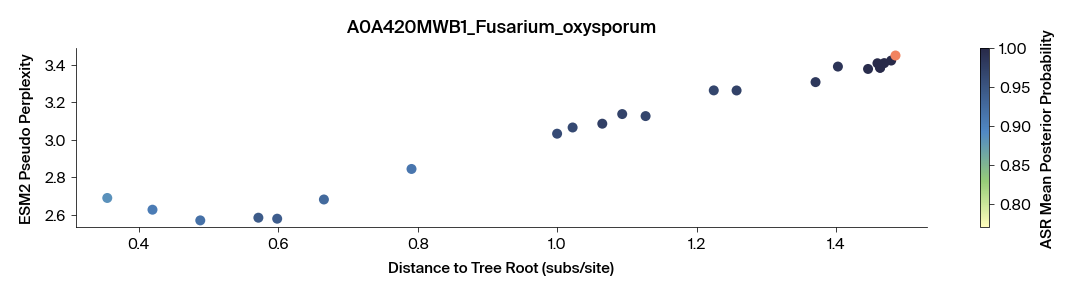

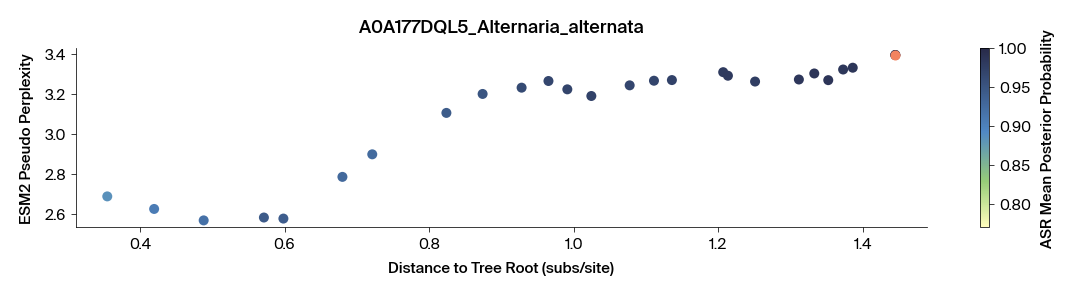

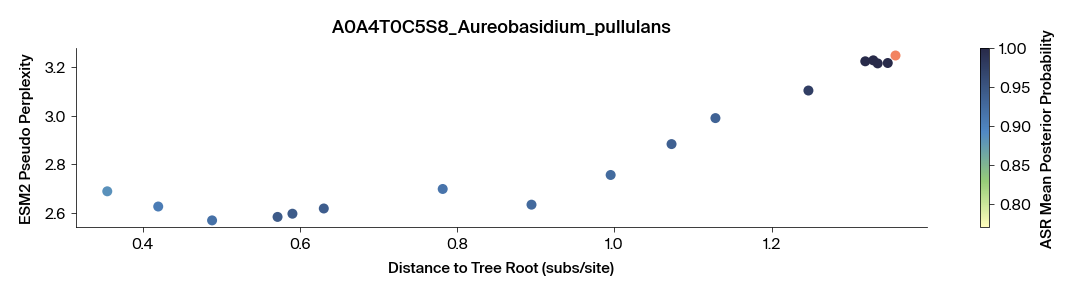

In [15]:
# | label: fig-10
# | fig-cap: Here is some text

plot_evo_path(iso_scores, iso_tree, 'A0A420MWB1_Fusarium_oxysporum', labels=False)
plot_evo_path(iso_scores, iso_tree, 'A0A177DQL5_Alternaria_alternata', labels=False)
plot_evo_path(iso_scores, iso_tree, 'A0A4T0C5S8_Aureobasidium_pullulans', labels=False)

##### Isomaltase reveals similar but attenuated patterns compared to ADA1. We observe the same decrease in pseudo-perplexity for recent ancestors relative to extant sequences, though less pronounced than with ADA1. This is followed by leveling off and slight increases for the oldest ancestors, again much less dramatic than the ADA1 pattern. These results confirm that ESM2's preference for ancestral sequences over native sequences extends to this second gene family. However, we don't observe the sharp increase in pseudo-perplexity seen with ADA1's most ancient ancestors, likely because isomaltase lacks reconstructions with comparably low posterior probabilities or similar branch length divergence.

##### We also generated consensus ancestral sequences for isomaltase and compared their ESM2 pseudo-perplexity scores to maximum likelihood ancestral sequences.


In [16]:
# generate isomaltase consensus ancestors

leaves_of_interest = ['A0A420MWB1_Fusarium_oxysporum', 'A0A177DQL5_Alternaria_alternata', 'A0A4T0C5S8_Aureobasidium_pullulans']
ancestors_of_interest = []

for entry in leaves_of_interest:
    ancestors_of_interest.extend(get_node_labels_leaf_to_root(iso_tree, entry))

ancestors_of_interest = list(set(ancestors_of_interest))

alignment_file = 'ASR/Isomaltase_ASR/isomaltase_dereplicated_final_recoded_mafft.fa'
name_conv_dict = 'ASR/Isomaltase_ASR/recoding_dict.txt'
gap_dict_json = 'ASR/Isomaltase_ASR/gap_positions.json'

consensus_seq_file = 'consensus_isomaltase_ancestors.fa'

records = []
for entry in ancestors_of_interest:
    consensus_seq = generate_node_consensus(iso_tree, entry, alignment_file, name_conv_dict, gap_dict_json)
    name = entry + '_consensus'
    record = SeqRecord(Seq(consensus_seq), id=name, description="")
    records.append(record)

# Write all consensus sequences to a FASTA file
with open(consensus_seq_file, 'w') as file:
    SeqIO.write(records, file, "fasta")

In [17]:
# retrieve esm2 scores for consensus seqs
consensus_file = 'ESM2_scoring/consensus_ancestors/consensus_isomaltase_ancestors_esm2_scores_650M.csv'
consensus_scores = pd.read_csv(consensus_file)
consensus_scores['orig_id'] = consensus_scores['sequence_id'].apply(lambda x: x.replace('_consensus', ''))
consensus_scores = consensus_scores[['orig_id', 'sequence', 'pseudo_perplexity']]
consensus_scores = consensus_scores.rename(columns={'sequence': 'consensus_seq', 'pseudo_perplexity': 'consensus_pppl', 'orig_id':'sequence_id'})


# add new consensus seqs and scores to scores df
iso_scores = iso_scores.merge(consensus_scores, how='left', on='sequence_id')

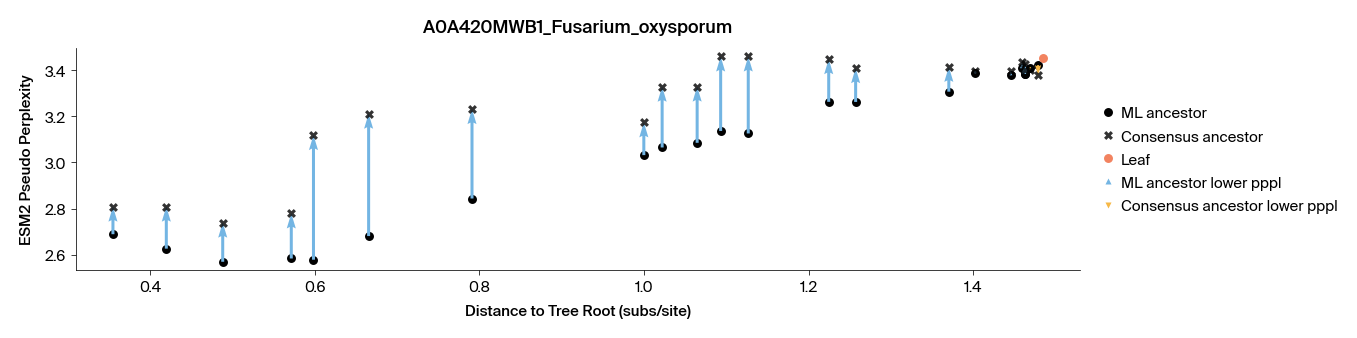

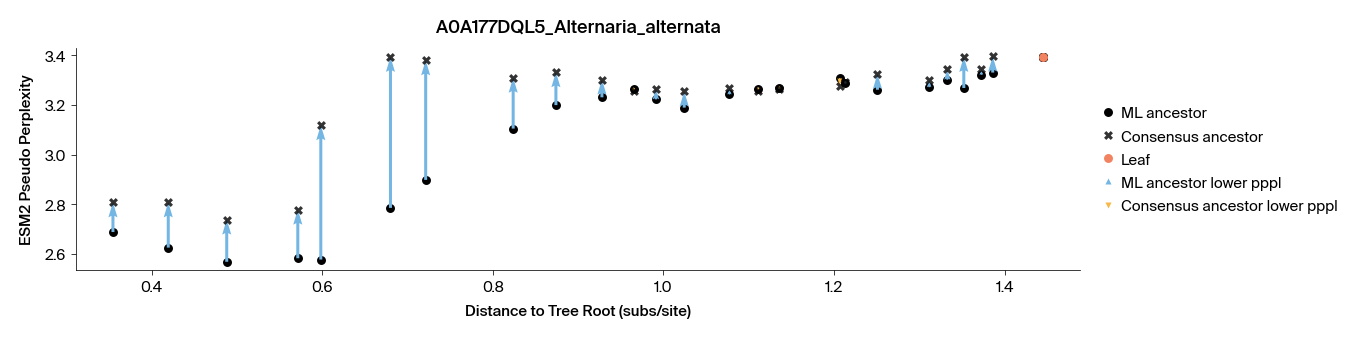

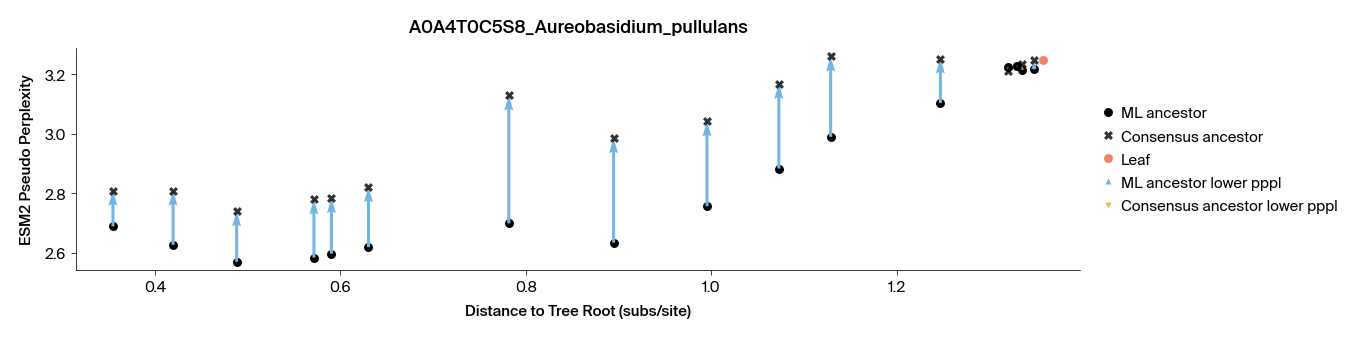

In [18]:
# | label: fig-11
# | fig-cap: Here is some text

plot_evo_path_quiver(iso_scores, iso_tree, 'A0A420MWB1_Fusarium_oxysporum')
plot_evo_path_quiver(iso_scores, iso_tree, 'A0A177DQL5_Alternaria_alternata')
plot_evo_path_quiver(iso_scores, iso_tree, 'A0A4T0C5S8_Aureobasidium_pullulans')

##### This comparison shows distinct behavior from ADA1. In virtually all cases, pseudo-perplexity scores for maximum likelihood ancestors were lower than consensus ancestors.Overall, the model greatly prefers maximum likelihood ancestors for isomaltase, suggesting the phylogenetic signal has been largely learned by the model, rather than simple amino acid frequency distributions.


##### We also tested these sequences using different sized ESM2 models to see if we observe differences between model sizes as with ADA1.  Below we show the normalized scores.


In [19]:
# load esm2 scores for isomaltase

iso_small_model_scores = pd.read_csv('ESM2_scoring/isomaltase_all_esm2_scores_8M.csv')
iso_med_model_scores = pd.read_csv('ESM2_scoring/isomaltase_all_esm2_scores_35M.csv')
iso_large_model_scores = pd.read_csv('ESM2_scoring/isomaltase_all_esm2_scores_150M.csv')
iso_huge_model_scores = pd.read_csv('ESM2_scoring/isomaltase_all_esm2_scores_3B.csv')

iso_small_model_scores['ML prob'] = iso_small_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_small_model_scores['bl_to_root'] = iso_small_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_med_model_scores['ML prob'] = iso_med_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_med_model_scores['bl_to_root'] = iso_med_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_large_model_scores['ML prob'] = iso_large_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_large_model_scores['bl_to_root'] = iso_large_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

iso_huge_model_scores['ML prob'] = iso_huge_model_scores['sequence_id'].apply(lambda x: np.mean([max(x) for x in iso_probs_dict[x]]) if x in iso_probs_dict else np.nan)
iso_huge_model_scores['bl_to_root'] = iso_huge_model_scores['sequence_id'].apply(lambda x: calc_branch_length_to_root_node(iso_tree, x[4:]) if x.startswith('node') else calc_branch_length_to_root_leaf(iso_tree, x))

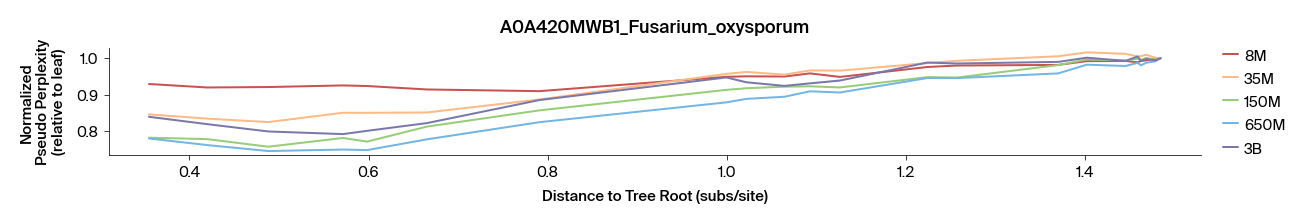

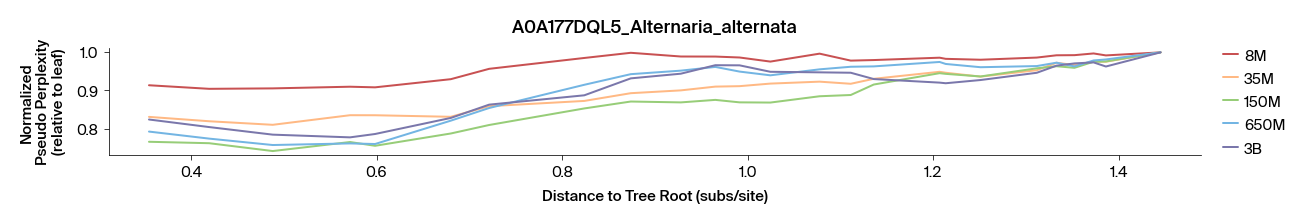

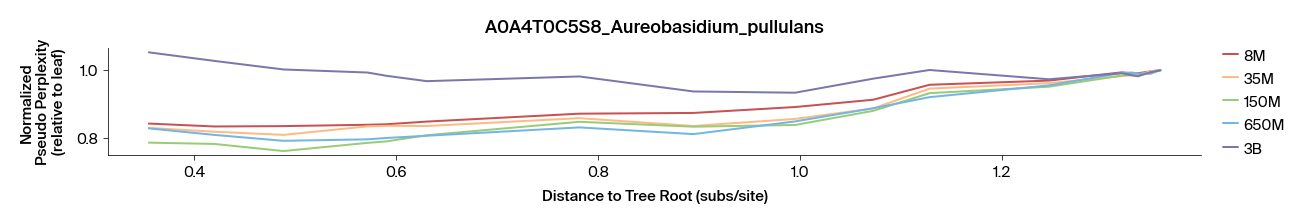

In [20]:
# | label: fig-12
# | fig-cap: Here is some text

plot_multiple_evo_lines([(iso_small_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '8M'),(iso_med_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '35M'),(iso_large_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '150M'),(iso_scores, 'A0A420MWB1_Fusarium_oxysporum', '650M'), (iso_huge_model_scores, 'A0A420MWB1_Fusarium_oxysporum', '3B')], iso_tree, normalize = True)
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A177DQL5_Alternaria_alternata', '8M'),(iso_med_model_scores, 'A0A177DQL5_Alternaria_alternata', '35M'),(iso_large_model_scores, 'A0A177DQL5_Alternaria_alternata', '150M'),(iso_scores, 'A0A177DQL5_Alternaria_alternata', '650M'), (iso_huge_model_scores, 'A0A177DQL5_Alternaria_alternata', '3B')], iso_tree, normalize = True)
plot_multiple_evo_lines([(iso_small_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '8M'),(iso_med_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '35M'),(iso_large_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '150M'),(iso_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '650M'), (iso_huge_model_scores, 'A0A4T0C5S8_Aureobasidium_pullulans', '3B')], iso_tree, normalize = True)

##### Here we observe a similar phenomena where the smallest models showed largely consistent pseudo-perplexity scores, while the largest models showed more pronounced increases in pseudo-perplexity with the oldest ancestors. This pattern was consistent with ADA1 observations but less dramatic. Nonetheless, this observation is consistent with the idea that selection of ESM2 model size is very important in interpreting the plausibility of ancestral sequences relative to native.

## Relationship between ASR confidence and ESM2 pseudo-perplexity

##### The isomaltase results prompted us to investigate whether a general relationship exists between maximum likelihood ancestral reconstruction posterior probabilities and ESM2 pseudo-perplexity. We pooled results from both ADA1 and isomaltase phylogenies, calculating pseudo-perplexity scores for all native and ancestral sequences using the 650M parameter model.

In [21]:
# pull data for all remaining ADA1 sequences
remaining_df = pd.read_csv('ESM2_scoring/ADA1_remaining_esm2_scores_650M.csv')
remaining_df = remaining_df[['sequence_id', 'sequence', 'pseudo_perplexity']]

# combine with original scores
all_scores = pd.read_csv('ESM2_scoring/ADA1_all_esm2_scores_650M.csv')
all_scores = all_scores[['sequence_id', 'sequence', 'pseudo_perplexity']]
full_data = pd.concat([remaining_df, all_scores])

# Add in ML posterior probabilities from ASR run
ml_probs_json = 'ASR/ADA1_ASR/posterior_probabilities_no_gaps.json'
with open(ml_probs_json) as f:
    probs_dict = json.load(f)
full_data['ML prob'] = full_data['sequence_id'].apply(
    lambda x: np.mean([max(x) for x in probs_dict[x]]) if x in probs_dict else np.nan)
full_data['ML prob'] = full_data['ML prob'].fillna(1.1)

# pull data for all iso native and ancestor
remaining_df = pd.read_csv('ESM2_scoring/isomaltase_remaining_esm2_scores_650M.csv')
remaining_df = remaining_df[['sequence_id', 'sequence', 'pseudo_perplexity']]

# combine with original scores
iso_scores = pd.read_csv('ESM2_scoring/isomaltase_all_esm2_scores_650M.csv')
iso_scores = iso_scores[['sequence_id', 'sequence', 'pseudo_perplexity']]
full_data_iso = pd.concat([remaining_df, iso_scores])

# Retrieve ML posterior probabilities from ASR run
ml_probs_json = 'ASR/Isomaltase_ASR/posterior_probabilities_no_gaps.json'
with open(ml_probs_json) as f:
    probs_dict_iso = json.load(f)
full_data_iso['ML prob'] = full_data_iso['sequence_id'].apply(
    lambda x: np.mean([max(x) for x in probs_dict_iso[x]]) if x in probs_dict_iso else np.nan)
full_data_iso['ML prob'] = full_data_iso['ML prob'].fillna(1.1)

# merge all data together
full_data_both = pd.concat([full_data, full_data_iso])
full_data_both = full_data_both.drop_duplicates()

# print sizes of each
print (f"Total ADA1 sequences: {len(full_data)}")
print (f"Total Isomaltase sequences: {len(full_data_iso)}")


Total ADA1 sequences: 461
Total Isomaltase sequences: 571


##### We can then view the relationship between ML posterior probability and ESM2 pseudo-perplexity for all of these sequences.

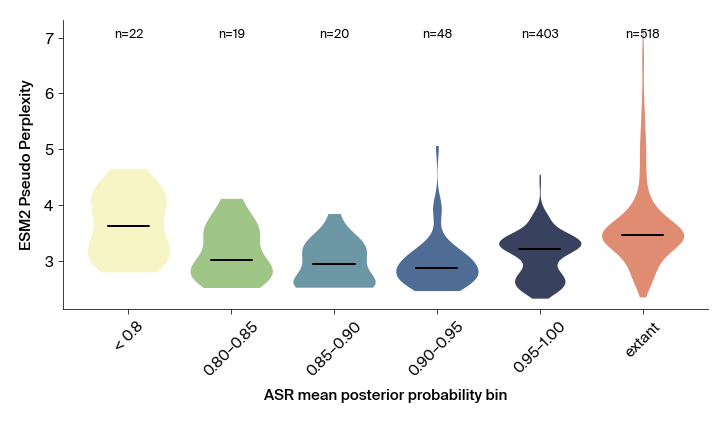

In [22]:
# | label: fig-13
# | fig-cap: Here is some text

from data_processing import violin_plot

bins = [0.7, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1]
bin_labels = ['< 0.8', '0.80–0.85', '0.85–0.90', '0.90–0.95', '0.95–1.00', 'extant']

custom_colors = {
    '< 0.8': '#fffdbd',
    '0.80–0.85': '#9dd07c',
    '0.85–0.90': '#649bb0',
    '0.90–0.95': '#446b9f',
    '0.95–1.00': '#313f65',
    'extant': '#F28360'
}

violin_plot(full_data_both, bins, bin_labels, custom_colors)


##### Here we do observe a broad pattern. We see the highest median pseudo-perplexity for extant sequences, then values decrease in the 0.95-1.0 and 0.90-0.95 posterior probability bins, level off in the 0.85-0.9 bins, and begin increasing again as probabilities drop below 0.85. While we would need to expand this analysis to many more genes to draw strong conclusions, this data is consistent with the idea that ancestral sequences show lower pseudo-perplexity scores than extant sequences until mean posterior probabilities drop below ~0.85, at which point the models become less confident in these sequences (for the 650M parameter ESM2 model).

## Discussion and Conclusions

##### Our analysis suggests that ESM2 protein language models have learned meaningful evolutionary information that extends beyond simple sequence memorization or frequency-based patterns. While it is difficult to select the "optimal" model size and to fully distinguish between evolutionary learning and overfitting to extant sequences, there are several indications that ESM2 is capable of genuinely learning evolutionary and phylogenetic relationships:

##### **Ancestral sequences are often considered more plausible than extant sequences**. Despite these sequences being absent from training sets, ESM2 consistently assigns lower pseudo-perplexity scores to many ancestral reconstructions compared to their extant descendants across both gene families and multiple species. 

##### **ESM2 can distinguish between high and low-quality ancestral reconstructions**. The most compelling evidence for genuine evolutionary understanding comes from the model's ability to discriminate between maximum likelihood and consensus ancestors. For high-confidence reconstructions, ESM2 consistently prefers maximum likelihood ancestors over simple consensus sequences, indicating that the model has internalized evolutionary principles beyond amino acid frequency distributions. This preference is particularly pronounced for recent ancestors and diminishes for ancient, poorly supported reconstructions, either due to the low support of these ancestors or divergence from trained sequences.

##### **Model size dramatically affects evolutionary sensitivity**. Large ESM2 models (650M and 3B parameters) demonstrate nuanced responses to ancestral age and reconstruction quality, showing strong confidence in high-quality ancestral reconstructions while becoming increasingly skeptical of low-confidence reconstructions as evolutionary distance from native increases. In contrast, smaller models show minimal sensitivity to evolutionary depth or reconstruction quality, with relatively flat pseudo-perplexity profiles across evolutionary time. This suggests that evolutionary understanding emerges as a property of model scale and has critical implications for selecting appropriate model sizes for evolutionary analysis.

##### Future work could explore other gene families with different phylogenetic structures, levels of conservation, and representation in the training data, in order to further probe these relationships. In particular, it would be interesting to explore whether the largest ESM2 models are in fact over-fit for native sequences, and if that is in part responsible for the decreased perceived plausibility of very ancient ancestors.  Using a gene family with very long branch lengths might allow a better investigation of this idea. In addition it would be interesting to explore other protein language models to see if they exhibit similar behavior.
